<a href="https://colab.research.google.com/github/adarsh-meher/MH---MathCoThon/blob/mathcothon_V1_Score0.91194/MH_Datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
data = files.upload()

In [ ]:
!conda install -c conda-forge scikit-garden 
!pip install lightgbm
!pip install hyperopt
!pip install catboost
!pip install rgf_python
!pip uninstall xgboost
!pip install https://s3-us-west-2.amazonaws.com/xgboost-nightly-builds/xgboost-1.4.0_SNAPSHOT%2B4224c08cacceba3f83f90e387c07aa6205a83bfa-py3-none-manylinux2010_x86_64.whl
!pip install mlxtend
!pip install category_encoders

/bin/bash: conda: command not found
     |████████████████████████████████| 69.2MB 41kB/s 
     |████████████████████████████████| 757kB 6.4MB/s 
Uninstalling xgboost-0.90:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/xgboost-0.90.dist-info/*
    /usr/local/lib/python3.7/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.90
     |████████████████████████████████| 166.7MB 55kB/s 
     |████████████████████████████████| 81kB 4.2MB/s 


In [ ]:
#import os
#!git clone https://github.com/h2oai/pystacknet
#os.chdir('/content/pystacknet/')
#!python setup.py install

In [ ]:
import pandas as pd
import numpy as np
import io
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import PowerTransformer,LabelEncoder

In [ ]:
train,test = pd.read_csv(io.BytesIO(data['train.csv'])),pd.read_csv(io.BytesIO(data['test.csv']))

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8245 entries, 0 to 8244
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                8245 non-null   int64  
 1   Levy              8245 non-null   object 
 2   Manufacturer      8245 non-null   object 
 3   Model             8245 non-null   object 
 4   Prod. year        8245 non-null   int64  
 5   Category          8245 non-null   object 
 6   Leather interior  8245 non-null   object 
 7   Fuel type         8245 non-null   object 
 8   Engine volume     8245 non-null   object 
 9   Mileage           8245 non-null   object 
 10  Cylinders         8245 non-null   int64  
 11  Gear box type     8245 non-null   object 
 12  Drive wheels      8245 non-null   object 
 13  Doors             8245 non-null   object 
 14  Wheel             8245 non-null   object 
 15  Color             8245 non-null   object 
 16  Airbags           8245 non-null   int64  


## **EDA and Feature Engineering**

### Assissing ID column

In [ ]:
train.ID.nunique()/train.shape[0]

0.983729271715964

In [ ]:
test.ID.nunique()/test.shape[0]

0.9909035779260158

Some id's are repeated

In [ ]:
train.ID.value_counts()[train.ID.value_counts()>1]

45815365    8
45815361    8
45815363    7
45815368    7
45723475    7
           ..
45809824    2
45815232    2
45812670    2
45813092    2
45041479    2
Name: ID, Length: 220, dtype: int64

In [ ]:
train[train.ID==45815368]

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
998,45815368,6899,-,HONDA,Stream,2004,Minivan,No,Petrol,1.7,0 km,4.0,Automatic,Front,04-May,Right-hand drive,Silver,4
4732,45815368,6899,-,HONDA,Stream,2004,Minivan,No,Petrol,1.7,0 km,4.0,Automatic,Front,04-May,Right-hand drive,Silver,4
5121,45815368,6899,-,HONDA,Stream,2004,Minivan,No,Petrol,1.7,0 km,4.0,Automatic,Front,04-May,Right-hand drive,Silver,4
5194,45815368,6899,-,HONDA,Stream,2004,Minivan,No,Petrol,1.7,0 km,4.0,Automatic,Front,04-May,Right-hand drive,Silver,4
9799,45815368,6899,-,HONDA,Stream,2004,Minivan,No,Petrol,1.7,0 km,4.0,Automatic,Front,04-May,Right-hand drive,Silver,4
11209,45815368,6899,-,HONDA,Stream,2004,Minivan,No,Petrol,1.7,0 km,4.0,Automatic,Front,04-May,Right-hand drive,Silver,4
16216,45815368,6899,-,HONDA,Stream,2004,Minivan,No,Petrol,1.7,0 km,4.0,Automatic,Front,04-May,Right-hand drive,Silver,4


In [ ]:
ids_mult_rows = train.ID.value_counts()[train.ID.value_counts()>1].index.values.tolist()

In [ ]:
def return_nunique(x):
  return len(set(x))
train[train.ID.isin(ids_mult_rows)].groupby(['ID'])['Price'].apply(lambda x : return_nunique(x)).sum()

220

Duplicate rows have all unique values in price column. We can apply drop duplicate to remove them

In [ ]:
train = train.drop_duplicates()

In [ ]:
train.ID.value_counts()[train.ID.value_counts()>1]

Series([], Name: ID, dtype: int64)

In [ ]:
#test = test.drop_duplicates()
#test.ID.value_counts()[test.ID.value_counts()>1]

### **Analyzing target variable**

In [ ]:
target = 'Price'

In [ ]:
train.Price.describe()

count    1.892400e+04
mean     1.858744e+04
std      1.921356e+05
min      1.000000e+00
25%      5.331000e+03
50%      1.317200e+04
75%      2.206300e+04
max      2.630750e+07
Name: Price, dtype: float64

In [ ]:
tar_seq = train[target].values
for i in range(95,101,1):
  print('Value at percentile {0} : {1}'.format(i,np.percentile(tar_seq,i)))

Value at percentile 95 : 49410.2999999998
Value at percentile 96 : 52959.0
Value at percentile 97 : 57189.840000000346
Value at percentile 98 : 66485.0
Value at percentile 99 : 84675.0
Value at percentile 100 : 26307500.0


In [ ]:
sudden_inc_vals = [627220,   872946, 26307500]

In [ ]:
train[train.Price.isin(sudden_inc_vals)]

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
1225,45795524,627220,-,MERCEDES-BENZ,G 65 AMG 63AMG,2020,Jeep,Yes,Petrol,6.3 Turbo,0 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,12
8541,45761204,872946,2067,LAMBORGHINI,Urus,2019,Universal,Yes,Petrol,4,2531 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,0
16983,45812886,26307500,-,OPEL,Combo,1999,Goods wagon,No,Diesel,1.7,99999 km,4.0,Manual,Front,02-Mar,Left wheel,Blue,0


In [ ]:
train = train.sort_values(ascending = True,by = ['Price'])
train.index = range(train.shape[0])

In [ ]:
train_rem_out = train.loc[:18920,:]

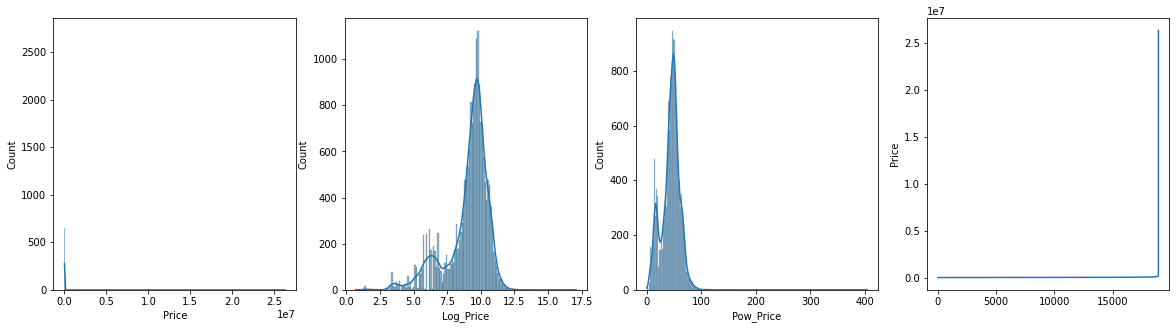

In [ ]:
train['Log_Price'] = train['Price'].map(lambda x : np.log(x+1))
pow_trans = PowerTransformer(method='box-cox',standardize=False)
train['Pow_Price'] = pow_trans.fit_transform(train['Price'].values.reshape(-1,1))

fig,axs = plt.subplots(figsize = (20,5),nrows = 1,ncols = 4)
sb.histplot(data=train, x="Price", kde=True,ax=axs[0])
sb.histplot(data=train, x="Log_Price", kde=True,ax=axs[1])
sb.histplot(data=train, x="Pow_Price", kde=True,ax=axs[2])
sb.lineplot(x = train.index,y=train.Price,ax=axs[3])
plt.show()

### Analyzing feature columns

In [ ]:
train.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Log_Price,Pow_Price
0,45765530,1,-,OPEL,Astra,1999,Sedan,Yes,Petrol,1.6,122231 km,4.0,Manual,Front,04-May,Left wheel,Silver,4,0.693147,0.000000
1,45772201,1,1202,CHEVROLET,Lacetti,2006,Hatchback,No,Petrol,1.6,200000 km,4.0,Manual,Front,04-May,Left wheel,Black,2,0.693147,0.000000
2,45776614,3,-,NISSAN,X-Terra,2004,Jeep,No,Petrol,3.3,323200 km,6.0,Automatic,4x4,04-May,Left wheel,Black,2,1.386294,1.283778
3,45761457,3,-,BMW,525,1995,Sedan,No,Petrol,2.8,2147483647 km,6.0,Manual,Rear,04-May,Left wheel,Black,3,1.386294,1.283778
4,45654295,3,900,KIA,Sportage,2015,Jeep,No,Petrol,2.4,50345 km,4.0,Tiptronic,4x4,04-May,Left wheel,Blue,12,1.386294,1.283778


In [ ]:
train_copy=train.copy()
test_copy=test.copy()

In [ ]:
########################### Replacing '-' with 0
train_copy['Levy'] = train_copy.Levy.map(lambda x : 0 if x=='-' else int(x))
test_copy['Levy'] = test_copy.Levy.map(lambda x : 0 if x=='-' else int(x))

######################### Number of years passed from production year
train_copy['num_years_passed'] = 2021-train_copy['Prod. year']
test_copy['num_years_passed'] = 2021-test_copy['Prod. year']

####################### Converting engine volume into float
train_copy['Engine volume'] = train_copy['Engine volume'].map(lambda x: float(x.split()[0]))
test_copy['Engine volume'] = test_copy['Engine volume'].map(lambda x: float(x.split()[0]))

###################### Extract number from mileage
train_copy.Mileage = train_copy['Mileage'].map(lambda x: float(x.split()[0]))
test_copy.Mileage = test_copy['Mileage'].map(lambda x: float(x.split()[0]))

###################### Convert door to numeric
train_copy.Doors = train_copy.Doors.map(lambda x : int(x.split('-')[0]) if '-' in x else int(x.split('>')[1]))
test_copy.Doors = test_copy.Doors.map(lambda x : int(x.split('-')[0]) if '-' in x else int(x.split('>')[1]))

In [ ]:
encoding_cols = ['Manufacturer','Category','Leather interior','Fuel type','Gear box type','Drive wheels','Wheel','Color']

In [ ]:
'''
def label_enc_cols(train_data,test_data,cols_to_enc=None):
  for c in cols_to_enc:
    labenc = LabelEncoder()
    df1 = pd.concat([train_data[c],test_data[c]],axis =0)
    labenc.fit(df1)
    train_data[c] = labenc.transform(train_data[c])
    test_data[c] = labenc.transform(test_data[c])
  return train_data,test_data
train_copy,test_copy = label_enc_cols(train_copy,test_copy,cols_to_enc=encoding_cols)
'''

'\ndef label_enc_cols(train_data,test_data,cols_to_enc=None):\n  for c in cols_to_enc:\n    labenc = LabelEncoder()\n    df1 = pd.concat([train_data[c],test_data[c]],axis =0)\n    labenc.fit(df1)\n    train_data[c] = labenc.transform(train_data[c])\n    test_data[c] = labenc.transform(test_data[c])\n  return train_data,test_data\ntrain_copy,test_copy = label_enc_cols(train_copy,test_copy,cols_to_enc=encoding_cols)\n'

In [ ]:
test_copy.shape

(8245, 19)

### **Describing each variable and calculating summary statistics**

In [ ]:
def create_summ_stats(data,cols_to_remove=None,target_col=None):
  cols_to_use = list(set(data.columns)-set(cols_to_remove)) if cols_to_remove!=None else data.columns.tolist()
  df1 = pd.DataFrame(columns =['ColName','Dtype','NumUnique','PropNA','Stats'],index=[0])
  df2 = pd.DataFrame()
  for c in cols_to_use:
    df1['ColName']=c
    df1['Dtype']=str(data[c].dtype)
    df1['NumUnique']=data[c].nunique()
    df1['PropNA']=data[c].isnull().sum()/data.shape[0]
    df1['ColCat'] = 'binary' if (df1['NumUnique'].values[0]<=2) else 'categorical' if ((df1['NumUnique'].values[0]>2) & (df1['NumUnique'].values[0]<15)) else 'continuous'
    df1['Stats'] = str({ j:data[c].describe().to_dict()[j] for j in ['max','mean','min','std','50%']}) if ((df1['ColCat'].values[0]=='continuous') & (df1['Dtype'].values[0]!='object')) else 'None'
    df2=df2.append(df1)
  return df2

In [ ]:
create_summ_stats(train_copy,cols_to_remove=['ID'])

,ColName,Dtype,NumUnique,PropNA,Stats,ColCat
0,Cylinders,float64,13,0.0,None,categorical
0,Category,object,11,0.0,None,categorical
0,Fuel type,object,7,0.0,None,categorical
0,Levy,int64,559,0.0,"{'max': 11714.0, 'mean': 632.8864933417882, 'm...",continuous
0,Engine volume,float64,65,0.0,"{'max': 20.0, 'mean': 2.3062513210736757, 'min...",continuous
0,Mileage,float64,7687,0.0,"{'max': 2147483647.0, 'mean': 1555372.71892834...",continuous
0,Drive wheels,object,3,0.0,None,categorical
0,Log_Price,float64,2315,0.0,"{'max': 17.085364665609077, 'mean': 9.02898089...",continuous
0,Model,object,1590,0.0,None,continuous
0,Prod. year,int64,54,0.0,"{'max': 2020.0, 'mean': 2010.914235890932, 'mi...",continuous


### Analyzing remaining features

In [ ]:
t1 = (train_copy.Manufacturer.value_counts()/train_copy.shape[0]).reset_index()
t1['cum_sum']=  np.cumsum(t1['Manufacturer'])
t1.head(30)

,index,Manufacturer,cum_sum
0,HYUNDAI,0.197051,0.197051
1,TOYOTA,0.190552,0.387603
2,MERCEDES-BENZ,0.107958,0.495561
3,FORD,0.057493,0.553054
4,CHEVROLET,0.055327,0.608381
5,BMW,0.054745,0.663126
6,HONDA,0.050729,0.713855
7,LEXUS,0.048985,0.762841
8,NISSAN,0.034084,0.796925
9,VOLKSWAGEN,0.030173,0.827098


In [ ]:
t2 = train_copy.groupby(['Manufacturer'])['Price'].agg([np.count_nonzero,np.min,np.mean,np.median,np.max,np.std]).sort_values(ascending = False,by=['count_nonzero'])
t2.head(20)

,count_nonzero,amin,mean,median,amax,std
Manufacturer,,,,,,
HYUNDAI,3729,3,22306.000805,18240.0,131308,1.590435e+04
TOYOTA,3606,3,14302.447865,12544.0,172486,1.422044e+04
MERCEDES-BENZ,2043,3,18590.331375,10976.0,627220,2.808678e+04
FORD,1088,36,15411.850184,12829.0,137885,1.769531e+04
CHEVROLET,1047,1,14894.873926,13297.0,106627,1.216170e+04
BMW,1036,3,20609.468147,14113.0,288521,2.333154e+04
HONDA,960,20,14162.073958,9800.5,124989,1.555427e+04
LEXUS,927,31,20052.594391,9565.0,260296,2.577661e+04
NISSAN,645,3,9835.840310,8154.0,47042,7.962707e+03


In [ ]:
train_copy.groupby(['Category'])['Price'].agg([np.count_nonzero,np.min,np.mean,np.median,np.max,np.std]).sort_values(ascending = False,by=['count_nonzero'])

,count_nonzero,amin,mean,median,amax,std
Category,,,,,,
Sedan,8600,1,14202.733837,11964.0,288521,1.438056e+04
Jeep,5378,3,23760.507252,19105.0,627220,2.526570e+04
Hatchback,2799,1,11354.611647,10349.0,78829,9.022618e+03
Minivan,633,50,20601.456556,17710.0,106668,1.380916e+04
Coupe,528,3,21282.356061,14261.5,308906,2.870564e+04
Universal,361,1490,25350.628809,17249.0,872946,4.793880e+04
Microbus,299,100,18538.933110,15524.0,95000,1.374063e+04
Goods wagon,229,50,124840.104803,8781.0,26307500,1.737807e+06
Pickup,51,314,29362.392157,21953.0,116036,2.879105e+04


OHE category

In [ ]:
train_copy['manu_cat'] = train_copy.Manufacturer + '_' + train_copy.Category
test_copy['manu_cat'] = test_copy.Manufacturer + '_' + test_copy.Category

In [ ]:
t3 = train_copy.groupby(['manu_cat'])['Price'].agg([np.count_nonzero,np.min,np.mean,np.median,np.max,np.std]).sort_values(ascending = False,by=['count_nonzero'])
t3.head(30)

,count_nonzero,amin,mean,median,amax,std
manu_cat,,,,,,
HYUNDAI_Sedan,2096,3,15459.497615,15053.0,73620,10975.443974
TOYOTA_Sedan,1719,9,13253.531704,12231.0,87811,12265.310879
MERCEDES-BENZ_Sedan,1203,3,14405.211139,8938.0,172486,18401.987771
TOYOTA_Hatchback,1135,3,13063.155066,13172.0,57607,8294.050498
HYUNDAI_Jeep,991,94,34402.746720,33908.0,131308,17965.449569
LEXUS_Jeep,656,31,22393.501524,11290.0,260296,28239.032280
TOYOTA_Jeep,619,25,19190.324717,10663.0,172486,23612.931180
CHEVROLET_Sedan,559,3,14474.703041,13172.0,63826,10352.017816
HONDA_Hatchback,516,20,10714.914729,8781.0,78829,11473.307374


In [ ]:
train_copy.groupby(['Fuel type'])['Price'].agg([np.count_nonzero,np.min,np.mean,np.median,np.max,np.std]).sort_values(ascending = False,by=['count_nonzero'])

,count_nonzero,amin,mean,median,amax,std
Fuel type,,,,,,
Petrol,9944,1,17391.153459,12890,872946,22270.903382
Diesel,4001,3,30684.792802,20438,26307500,415995.990198
Hybrid,3539,9,10845.476688,10036,133284,11440.934416
LPG,885,3,13320.505085,11604,68681,7252.934869
CNG,469,6,8186.859275,7370,42337,5083.799008
Plug-in Hybrid,85,1019,23650.917647,22580,94083,10913.254511
Hydrogen,1,20385,20385.000000,20385,20385,NaN


In [ ]:
train_copy[['Levy','Engine volume','Cylinders','Doors','Mileage','Airbags','Log_Price']].corr()

,Levy,Engine volume,Cylinders,Doors,Mileage,Airbags,Log_Price
Levy,1.000000,0.378117,0.251632,0.096430,-0.021203,0.125015,-0.057257
Engine volume,0.378117,1.000000,0.777228,-0.017697,-0.006292,0.221991,-0.021627
Cylinders,0.251632,0.777228,1.000000,-0.036033,-0.001720,0.174112,-0.042971
Doors,0.096430,-0.017697,-0.036033,1.000000,-0.006287,0.048088,-0.017282
Mileage,-0.021203,-0.006292,-0.001720,-0.006287,1.000000,-0.009174,-0.019186
Airbags,0.125015,0.221991,0.174112,0.048088,-0.009174,1.000000,-0.096414
Log_Price,-0.057257,-0.021627,-0.042971,-0.017282,-0.019186,-0.096414,1.000000


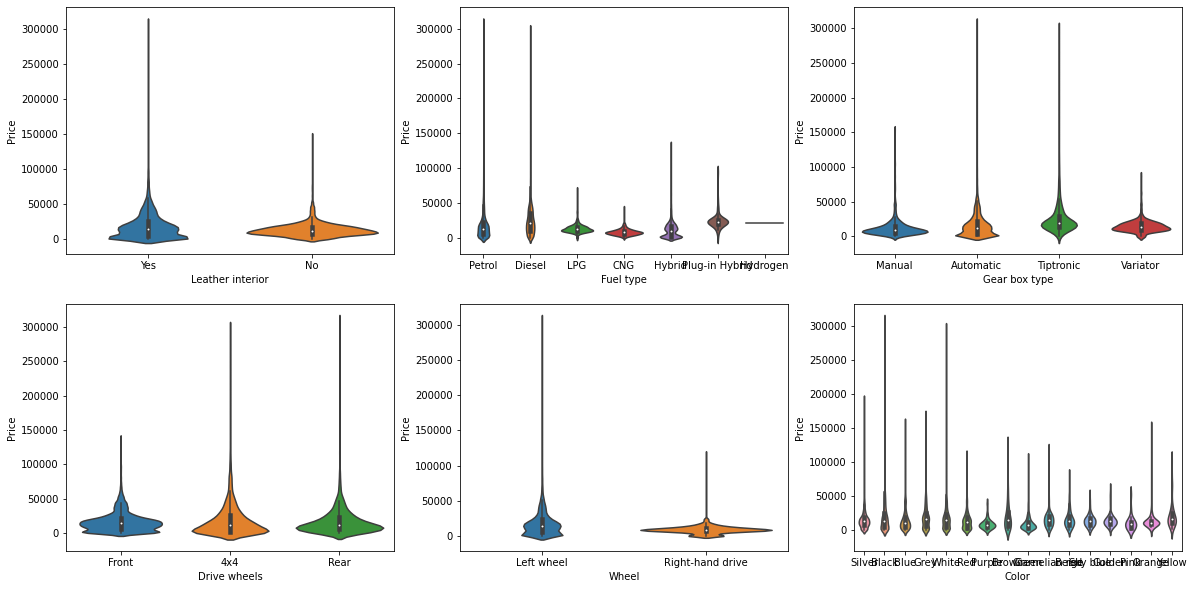

In [ ]:
fig,axs =  plt.subplots(figsize = (20,10),nrows=2,ncols=3)
cols_to_plot = ['Leather interior','Fuel type','Gear box type','Drive wheels','Wheel','Color']
indxs = [[i,j] for i in range(2) for j in range(3)]
for i,j in zip(indxs,cols_to_plot):
  sb.violinplot(x=train_rem_out[j],y=train_rem_out['Price'],ax=axs[i[0],i[1]])
plt.show()

In [ ]:
train_copy['leat_gear'] = train_copy['Leather interior'] + '_' + train_copy['Gear box type']
test_copy['leat_gear'] = test_copy['Leather interior'] + '_' + test_copy['Gear box type']

In [ ]:
########################## Applying linear regression between target and categorical variables
cat_reg = ['Leather interior','Fuel type','Gear box type','Drive wheels','Wheel','Color','Manufacturer','Category','manu_cat','leat_gear']
import statsmodels.api as sm
for i in cat_reg:
  X = pd.get_dummies(train_copy[i],columns=[i])
  #X = sm.add_constant(X)
  Y=train_copy.Log_Price.values
  model = sm.OLS(Y,X)
  results = model.fit()
  print('Regressor ',i,' Corr : ',str(np.sqrt(results.rsquared)),' Rsq : ',str(results.rsquared))

Regressor  Leather interior  Corr :  0.022383660732896292  Rsq :  0.0005010282678054034
Regressor  Fuel type  Corr :  0.2491630531806783  Rsq :  0.06208222707031752
Regressor  Gear box type  Corr :  0.22414306919087545  Rsq :  0.05024011546630558
Regressor  Drive wheels  Corr :  0.0728323683526361  Rsq :  0.005304553879854068
Regressor  Wheel  Corr :  0.08426772881355848  Rsq :  0.007101050119395436
Regressor  Color  Corr :  0.06721182890429482  Rsq :  0.004517429944660201
Regressor  Manufacturer  Corr :  0.2718185264139605  Rsq :  0.07388531130185694
Regressor  Category  Corr :  0.16910789691761258  Rsq :  0.02859748079989788
Regressor  manu_cat  Corr :  0.3516155079666885  Rsq :  0.1236334654426724
Regressor  leat_gear  Corr :  0.23392843492699886  Rsq :  0.05472251266739514


### **Model training,cross validation and prediction**

In [ ]:
cols_to_drop = ['ID','Model','Price','Log_Price','Pow_Price']
bin_cols = ['Leather interior','Wheel']
cols_to_ohe = ['Drive wheels', 'Gear box type', 'Fuel type', 'leat_gear','manu_cat']
cols_to_enc=['Color', 'Manufacturer','Category']
num_cols=['Airbags', 'Engine volume','Mileage','Prod. year','num_years_passed','Levy']

In [ ]:
from sklearn.model_selection import GridSearchCV,cross_val_score,cross_val_predict,train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_log_error,make_scorer
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import StackingRegressor,GradientBoostingRegressor,RandomForestRegressor,ExtraTreesRegressor
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.linear_model import SGDRegressor,HuberRegressor,ElasticNetCV,LassoCV,LinearRegression
from category_encoders import target_encoder,leave_one_out,cat_boost,count 
from sklearn.compose import make_column_selector
from sklearn.compose import TransformedTargetRegressor
SEED = 1993

In [ ]:
train_copy = train_copy.sample(frac=1).reset_index().drop(['index'],axis=1)
train1 = train_copy.drop(cols_to_drop,axis=1)
train1['Flag']='train'
test1 = test_copy.drop(list(set(cols_to_drop)-set(['Log_Price','Pow_Price'])),axis=1)
test1['Flag']='test'
comb_data = pd.concat([train1,test1],axis=0)

In [ ]:
############################### Encode binary columns
if bin_cols!=None:
  labenc=LabelEncoder()
  for c in bin_cols:
    comb_data[c]=labenc.fit_transform(comb_data[c])

In [ ]:
############################## Encode OHE columns
if cols_to_ohe!=None:
  for c in cols_to_ohe:
    comb_data=pd.get_dummies(comb_data,columns=[c],drop_first=True)

In [ ]:
train1 = comb_data[comb_data.Flag == 'train']
test1 = comb_data[comb_data.Flag == 'test']

In [ ]:
def rmsle_func(actual,predicted):
  predicted=np.abs(predicted)
  return np.sqrt(mean_squared_log_error(actual, predicted))
rmsle_score = make_scorer(rmsle_func,greater_is_better=False)

In [ ]:
xgb.__version__

'1.4.0-SNAPSHOT'

In [ ]:
def score(params):
    print("Training with params: ")
    print(params)
    #num_round = int(params['n_estimators'])
    #del params['n_estimators']
    #dtrain = xgb.DMatrix(train_features, label=y_train)
    #dvalid = xgb.DMatrix(valid_features, label=y_valid)
    #watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    #gbm_model = xgb.train(params, dtrain, num_round,
    #                      evals=watchlist,
    #                      verbose_eval=True)
    #predictions = gbm_model.predict(dvalid,
    #                                ntree_limit=gbm_model.best_iteration + 1)
    
    params['depth'] = int(params['depth'])
    params['iterations'] = int(params['iterations'])
    params['border_count'] = int(params['border_count'])
    cv=5
    
    pipe1 = Pipeline(steps=[('preprocessor', preprocessor),
                        ('create_df', ConvArrToDF(col_names=range(train_copy.drop(cols_to_drop,axis = 1).shape[1]))),
                      ('model', CatBoostRegressor(random_state=1993,cat_features=cols_to_enc,verbose=0,**params))])
    cp=cross_val_predict(pipe1,train_copy.drop(cols_to_drop,axis = 1),train_copy[target],verbose=10,cv=5)
    split_pt = len(cp) // cv + 1
    split_arr=[ split_pt+split_pt*i if i<cv-1 else len(cp)  for i in range(cv)]
    cp_split_arr = np.split(cp,split_arr)[:-1]
    act_split_arr=np.split(train_copy[target].values,split_arr)[:-1]
    score = np.mean([ rmsle_func(act,pred) for act,pred in zip(act_split_arr,cp_split_arr)])
    #score = rmsle_func(y_valid, predictions)
    # TODO: Add the importance for the selected features
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = score
    return {'loss': loss, 'status': STATUS_OK}



In [ ]:
def optimize(random_state=SEED):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    '''
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        #'eval_metric': 'rmsle',
        'objective': 'reg:squaredlogerror',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': random_state
    }
    '''
    space = {
        'depth': hp.quniform("depth", 3, 15, 1),
        'border_count': hp.uniform ('border_count', 32, 255),
        'learning_rate': hp.loguniform('learning_rate', -5.0, -2),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 8),
        'iterations' : hp.uniform('iterations',500,2000)
       }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=30)
    return best

In [ ]:
#train_features,valid_features,y_train,y_valid = train_test_split(train_copy.drop(cols_to_drop,axis=1),train_copy[target], test_size=0.2,
#                                random_state=SEED,shuffle=True)

In [ ]:
#best_hyperparams = optimize()
#print("The best hyperparameters are: ", "\n")
#print(best_hyperparams)
#xgb_params = {'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.17500000000000002, 'gamma': 0.9, 'max_depth': 3, 'min_child_weight': 2.0, 'n_estimators': 462.0, 'objective': 'reg:squaredlogerror', 'seed': 1993, 'silent': 1, 'subsample': 0.75, 'tree_method': 'exact'}

In [ ]:
class ConvArrToDF(BaseEstimator, TransformerMixin):
  def __init__(self,num_prev_pipe=None):
    self.num_prev_pipe=num_prev_pipe
  
  def fit(self,X,y=None):
    return self
  
  def transform(self,X,y=None):
    X = pd.DataFrame(X)
    X = pd.concat([X.loc[:,self.num_prev_pipe:],X.loc[:,list(range(self.num_prev_pipe))]],axis=1)
    float_cols,oth_cols=0,0
    for i in X.columns:
      try:
        X.loc[:,i]=X.loc[:,i].astype(float)
        float_cols=float_cols+1
      except:
        X.loc[:,i]=X.loc[:,i].astype(object)
        oth_cols=oth_cols+1
    if oth_cols>0:
      X=pd.concat([X.select_dtypes(include='float'),X.select_dtypes(include='object')],axis =1)
    X.columns=range(X.shape[1])
    return X


In [ ]:
total_cols= train1.shape[1]
len_enc_cols=len(cols_to_enc)
cols_to_enc_ind = list(range(total_cols-len_enc_cols,total_cols))

In [ ]:
print(train1.shape)
print(test1.shape)
train1 = pd.concat([train1.select_dtypes(exclude='object'),train1.select_dtypes(include='object')],axis=1)
test1 = pd.concat([test1.select_dtypes(exclude='object'),test1.select_dtypes(include='object')],axis=1)
print(train1.shape)
print(test1.shape)

(18924, 323)
(8245, 323)
(18924, 323)
(8245, 323)


In [ ]:
space = {
        'n_estimators': 1000,
        'eta': 0.01,
        'objective' :  'reg:squaredlogerror',
        'booster': 'gbtree',
        'tree_method': 'exact',
        'seed': 1993
    }
numeric_features=['Mileage','Prod. year']
numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, [1,4]),
        ('cat_trans',target_encoder.TargetEncoder(),make_column_selector(dtype_include='object'))],remainder='passthrough')

pipe1 = Pipeline(steps=[('preprocessor', preprocessor),
                      #  ('create_df', ConvArrToDF(col_names=range(train_copy.drop(cols_to_drop,axis = 1).shape[1]))),
                      #('model', SGDRegressor(loss='huber',penalty='elasticnet',shuffle=True,random_state=1993))])
                      ('model', GradientBoostingRegressor(n_estimators=1000,learning_rate=0.01,random_state=1993,max_depth=10))])

pipe2 = Pipeline(steps=[('preprocessor', preprocessor),
                      #  ('create_df', ConvArrToDF(col_names=range(train_copy.drop(cols_to_drop,axis = 1).shape[1]))),
                      #('model', ElasticNetCV(alphas = [1, 0.1, 0.001, 0.0005,2,5,10],max_iter=10000,random_state=1993))])
                      ('model', xgb.XGBRegressor(**space,random_state=1993))])

pipe3 = Pipeline(steps=[('preprocessor', preprocessor),
                      #  ('create_df', ConvArrToDF(col_names=range(train_copy.drop(cols_to_drop,axis = 1).shape[1]))),
                      #('model', LassoCV(alphas = [1, 0.1, 0.001, 0.0005,2,5,10]))])
                      ('model', LGBMRegressor(max_depth=10,learning_rate=0.01,n_estimators=1000,random_state=1993))])

pipe4 = Pipeline(steps=[('create_df', ConvArrToDF(num_prev_pipe=3)),
                        ('preprocessor', preprocessor),
                      ('model', GradientBoostingRegressor(n_estimators=1000,learning_rate=0.01,random_state=1993,max_depth=10))])


In [ ]:
estimators = [ ('pipe1', pipe1),('pipe2', pipe2),('pipe3', pipe3)]
stack_reg=StackingRegressor(estimators=estimators,final_estimator=pipe4,cv=5,passthrough=True,verbose=10)
trans_reg = TransformedTargetRegressor(regressor=stack_reg,func=np.log,inverse_func=np.exp)

In [70]:
cp=cross_val_predict(trans_reg,train1,train_copy['Price'],verbose=10,cv=5)
cp[cp==inf]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | ela

0:	learn: 1.5919953	total: 139ms	remaining: 2m 18s
1:	learn: 1.5828214	total: 174ms	remaining: 1m 26s
2:	learn: 1.5742420	total: 196ms	remaining: 1m 5s
3:	learn: 1.5653226	total: 231ms	remaining: 57.6s
4:	learn: 1.5567418	total: 276ms	remaining: 54.9s
5:	learn: 1.5480151	total: 311ms	remaining: 51.6s
6:	learn: 1.5397854	total: 351ms	remaining: 49.8s
7:	learn: 1.5313385	total: 387ms	remaining: 48s
8:	learn: 1.5231362	total: 422ms	remaining: 46.5s
9:	learn: 1.5149792	total: 458ms	remaining: 45.3s
10:	learn: 1.5067862	total: 494ms	remaining: 44.4s
11:	learn: 1.4990582	total: 515ms	remaining: 42.4s
12:	learn: 1.4913202	total: 550ms	remaining: 41.7s
13:	learn: 1.4835785	total: 589ms	remaining: 41.5s
14:	learn: 1.4761105	total: 625ms	remaining: 41s
15:	learn: 1.4686307	total: 664ms	remaining: 40.8s
16:	learn: 1.4611701	total: 701ms	remaining: 40.5s
17:	learn: 1.4537376	total: 737ms	remaining: 40.2s
18:	learn: 1.4467405	total: 777ms	remaining: 40.1s
19:	learn: 1.4397021	total: 802ms	remaining

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 30.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 11.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elap

0:	learn: 1.5786882	total: 58ms	remaining: 57.9s
1:	learn: 1.5697083	total: 93ms	remaining: 46.4s
2:	learn: 1.5610752	total: 128ms	remaining: 42.6s
3:	learn: 1.5522977	total: 164ms	remaining: 40.8s
4:	learn: 1.5439160	total: 200ms	remaining: 39.7s
5:	learn: 1.5354073	total: 237ms	remaining: 39.3s
6:	learn: 1.5271308	total: 280ms	remaining: 39.7s
7:	learn: 1.5190535	total: 316ms	remaining: 39.2s
8:	learn: 1.5110144	total: 352ms	remaining: 38.7s
9:	learn: 1.5030303	total: 387ms	remaining: 38.3s
10:	learn: 1.4950011	total: 424ms	remaining: 38.1s
11:	learn: 1.4872539	total: 460ms	remaining: 37.9s
12:	learn: 1.4792323	total: 501ms	remaining: 38s
13:	learn: 1.4716707	total: 536ms	remaining: 37.8s
14:	learn: 1.4641665	total: 571ms	remaining: 37.5s
15:	learn: 1.4566216	total: 610ms	remaining: 37.5s
16:	learn: 1.4493834	total: 644ms	remaining: 37.3s
17:	learn: 1.4421731	total: 680ms	remaining: 37.1s
18:	learn: 1.4350952	total: 722ms	remaining: 37.3s
19:	learn: 1.4281539	total: 757ms	remaining: 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 61.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elap

0:	learn: 1.5669541	total: 50.3ms	remaining: 50.3s
1:	learn: 1.5582075	total: 85.8ms	remaining: 42.8s
2:	learn: 1.5493304	total: 121ms	remaining: 40.2s
3:	learn: 1.5410293	total: 156ms	remaining: 38.8s
4:	learn: 1.5327871	total: 199ms	remaining: 39.6s
5:	learn: 1.5243344	total: 234ms	remaining: 38.7s
6:	learn: 1.5159226	total: 278ms	remaining: 39.4s
7:	learn: 1.5078430	total: 312ms	remaining: 38.7s
8:	learn: 1.4998563	total: 347ms	remaining: 38.2s
9:	learn: 1.4918275	total: 382ms	remaining: 37.8s
10:	learn: 1.4840429	total: 416ms	remaining: 37.4s
11:	learn: 1.4761987	total: 451ms	remaining: 37.2s
12:	learn: 1.4687144	total: 492ms	remaining: 37.4s
13:	learn: 1.4612166	total: 527ms	remaining: 37.1s
14:	learn: 1.4538404	total: 562ms	remaining: 36.9s
15:	learn: 1.4464622	total: 600ms	remaining: 36.9s
16:	learn: 1.4392696	total: 635ms	remaining: 36.7s
17:	learn: 1.4323770	total: 670ms	remaining: 36.5s
18:	learn: 1.4254605	total: 711ms	remaining: 36.7s
19:	learn: 1.4186245	total: 746ms	remai

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 91.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elap

0:	learn: 1.5796033	total: 47.3ms	remaining: 47.3s
1:	learn: 1.5710165	total: 83.3ms	remaining: 41.5s
2:	learn: 1.5622185	total: 118ms	remaining: 39.3s
3:	learn: 1.5539465	total: 154ms	remaining: 38.3s
4:	learn: 1.5455667	total: 190ms	remaining: 37.7s
5:	learn: 1.5372606	total: 225ms	remaining: 37.3s
6:	learn: 1.5290757	total: 271ms	remaining: 38.4s
7:	learn: 1.5208117	total: 306ms	remaining: 37.9s
8:	learn: 1.5129398	total: 342ms	remaining: 37.6s
9:	learn: 1.5049576	total: 378ms	remaining: 37.4s
10:	learn: 1.4970990	total: 413ms	remaining: 37.1s
11:	learn: 1.4894200	total: 449ms	remaining: 36.9s
12:	learn: 1.4816738	total: 494ms	remaining: 37.5s
13:	learn: 1.4740372	total: 531ms	remaining: 37.4s
14:	learn: 1.4667611	total: 568ms	remaining: 37.3s
15:	learn: 1.4592575	total: 604ms	remaining: 37.1s
16:	learn: 1.4520257	total: 639ms	remaining: 36.9s
17:	learn: 1.4449516	total: 679ms	remaining: 37s
18:	learn: 1.4381346	total: 730ms	remaining: 37.7s
19:	learn: 1.4312323	total: 767ms	remaini

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 121.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | ela

0:	learn: 1.5822754	total: 45.2ms	remaining: 45.2s
1:	learn: 1.5731148	total: 81ms	remaining: 40.4s
2:	learn: 1.5643312	total: 117ms	remaining: 38.8s
3:	learn: 1.5557502	total: 159ms	remaining: 39.5s
4:	learn: 1.5473620	total: 194ms	remaining: 38.6s
5:	learn: 1.5388846	total: 229ms	remaining: 37.9s
6:	learn: 1.5307096	total: 273ms	remaining: 38.7s
7:	learn: 1.5225225	total: 310ms	remaining: 38.4s
8:	learn: 1.5144206	total: 346ms	remaining: 38.1s
9:	learn: 1.5061975	total: 381ms	remaining: 37.7s
10:	learn: 1.4982368	total: 416ms	remaining: 37.4s
11:	learn: 1.4905395	total: 451ms	remaining: 37.1s
12:	learn: 1.4829953	total: 496ms	remaining: 37.6s
13:	learn: 1.4752792	total: 532ms	remaining: 37.5s
14:	learn: 1.4675097	total: 567ms	remaining: 37.3s
15:	learn: 1.4602142	total: 603ms	remaining: 37.1s
16:	learn: 1.4535346	total: 611ms	remaining: 35.3s
17:	learn: 1.4463867	total: 649ms	remaining: 35.4s
18:	learn: 1.4392139	total: 684ms	remaining: 35.3s
19:	learn: 1.4320483	total: 728ms	remaini

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 151.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 151.6min finished


NameError: ignored

In [ ]:
cv=5
split_pt = len(cp) // cv + 1
split_arr=[ split_pt+split_pt*i if i<cv-1 else len(cp)  for i in range(cv)]
cp_split_arr = np.split(cp,split_arr)[:-1]
act_split_arr=np.split(train_copy[target].values,split_arr)[:-1]
[ rmsle_func(act,pred) for act,pred in zip(act_split_arr,cp_split_arr)]

In [ ]:
trans_reg.fit(train1,train_copy['Price'])
predictions = trans_reg.predict(test1)
pd.DataFrame({'Price':predictions},index=range(len(predictions))).to_csv('GBM_Sub4.csv', index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 14.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 17.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 17.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

In [ ]:
def reduce_mem_usage(df):
    """
    Reduces memory usage for all columns in a Pandas DataFrame
    """
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings                       
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int32)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    else:
                        df[col] = df[col].astype(np.uint32)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    else:
                        df[col] = df[col].astype(np.int32)
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)

    # Print final result
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is after reduction is:",mem_usg," MB")
    return df, NAlist